In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter  # For counting occurrences of elements in lists or sequences
from nltk.corpus import stopwords
import nltk
import string  # For string manipulation, including handling punctuation
import json  # For working with JSON files or strings
import plotly.express as px  # For interactive data visualization
from plotly.subplots import make_subplots  # For creating subplots in Plotly
import plotly.graph_objects as go  # For detailed control over Plotly plots
from textblob import TextBlob  # For text analysis, including sentiment analysis
from wordcloud import WordCloud  # For generating word cloud visualizations

# Read a TSV file containing news articles
# Read_csv's parameters:
# - header: Row number to use as column names; None means no header
df_news = pd.read_csv("/content/news.tsv", header=None, sep='\t')

# Set column names for better readability
df_news.columns = [
    'article_id', 'category', 'subcategory', 'title', 'abstract',
    'url', 'title_entities', 'abstract_entities'
]

In [2]:
df_news.head()

,article_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [3]:
df_news.shape

(51282, 8)

In [4]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_id         51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [5]:
# check that IDs are unique
# duplicated: Checks for duplicate values in the specified column
df_news.duplicated('article_id').sum()

0

In [6]:
# titles are not unique
df_news.duplicated('title').sum()

848

In [7]:
df_news.isna().sum()

,0
article_id,0
category,0
subcategory,0
title,0
abstract,2666
url,0
title_entities,3
abstract_entities,4


In [8]:
# Number of articles per category
# Group the data by the 'category' column
# Select only the 'subcategory' column from the grouped data
# Count the values of this column per group and sort in descending order
df_news.groupby('category')['subcategory'].count().sort_values(ascending=False)

,subcategory
category,
news,15774
sports,14510
finance,3107
foodanddrink,2551
lifestyle,2479
travel,2350
video,2068
weather,2048
health,1885


In [9]:
# Number of subcategories
df_news['subcategory'].nunique()

264

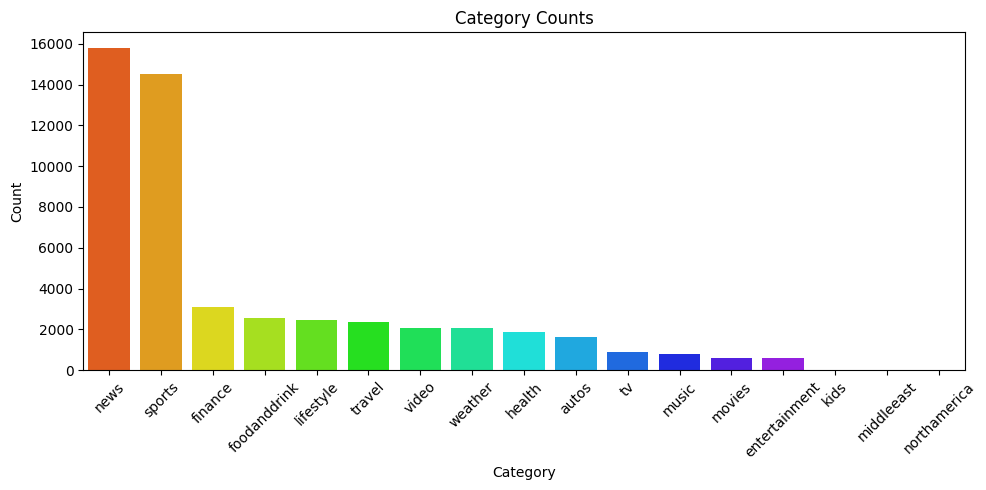

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort categories in descending order based on the number of articles
# .items(): Returns (key, value) pairs. Key is the category name, value is the number of articles (e.g., [('Sports', 50), ...])
# key=lambda x: -x[1]: Use the value (number of articles) as the sorting criterion.
# -x[1]: Converts the value to negative for descending order (e.g., [('Sports', 50), ('Politics', 30), ...])
# Extract only the keys (category names) from the sorted result
category_order = [x for x, count in sorted(Counter(df_news['category']).items(), key=lambda x: -x[1])]

# Aggregate the article counts by category
# .reset_index(): Converts the result of value_counts() into a DataFrame format,
# Moves the original category value into a new column (index). Index values are regenerated.
#    index       category <- e.g.
# 0  Sports       100
category_counts = df_news['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts = category_counts.sort_values('category', key=lambda x: [category_order.index(c) for c in x])

# Create a colorful color palette
colors = sns.color_palette("hsv", len(category_counts))

# Create frequency histogram by category using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(
    data=category_counts,
    x='category',
    y='count',
    hue='category',  # Assign `x` variable to `hue`
    palette=colors,
    dodge=False,
    legend=False
)
plt.xticks(rotation=45)
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [11]:
# .value_counts(): Counts unique (category, subcategory) pairs and returns a Series
c=df_news[['category','subcategory']].value_counts()

index=[]
# Iterate through the index of the value_counts result, which contains tuples of (category, subcategory)
for i in c.index:
    # Convert each tuple (category, subcategory) into a NumPy array
    index.append(np.array(i))
# Convert the list of NumPy arrays into a 2D NumPy array
# The resulting array will have two columns: one for 'category' and one for 'subcategory'
index=np.array(index)

distribution_df=pd.DataFrame(columns=['category','subcategory','values'])
distribution_df['category']=index[:,0]
distribution_df['subcategory']=index[:,1]
distribution_df['values']=c.values

px.bar(data_frame=distribution_df,x='category',y='values',color='subcategory')

In [12]:
# top 5 most popular subcategories for each of the top 5 categories
# df_news['category'].value_counts().nlargest(5): Selects the 5 categories with the most articles
top_categories = df_news['category'].value_counts().nlargest(5).index

# Generate count plots for subcategories within each top category
for category in top_categories:
    subcategory_counts = df_news[df_news['category'] == category]['subcategory'].value_counts().nlargest(10)
    fig = px.bar(subcategory_counts, x=subcategory_counts.index, y=subcategory_counts.values,
                 labels={'x': 'subcategory', 'y': 'Count'}, title=f"Subcategories for {category}")
    fig.update_xaxes(tickangle=50) # Rotate x-axis labels for better readability
    fig.show()

In [13]:
# most popular titles per category
df_news.groupby('category')['title'].value_counts().nlargest(10)

category      title                                                                        
news          Photos of the Day                                                                15
lifestyle     Look of the Day                                                                  14
sports        Video appears to show Astros stealing signs against Danny Farquhar                6
foodanddrink  Thanksgiving Recipe Searches Reveal Florida's Tastes                              5
music         New and upcoming releases                                                         5
news          Microsoft vows to 'honor' California's sweeping privacy law across entire US      5
sports        Friday's Scores                                                                   5
              Yankees make crucial error against Jose Altuve in 9th inning of ALCS clincher     5
              Yu Darvish sends hilarious tweet about Astros cheating scandal                    5
video         Morning news briefing from CNN                                                    5
Name: count, dtype: int64

In [14]:
# Download stopwords
import nltk
nltk.download('stopwords')

# Load stopwords
from nltk.corpus import stopwords

# Create a copy of the original DataFrame for word count analysis
# Avoids modifying the original dataset
df_word_count = df_news.copy()

# Calculate sentiment polarity of the title column
# TextBlob(x).sentiment.polarity:
# - Returns a value between -1 (negative sentiment) and 1 (positive sentiment)
df_word_count['title_polarity'] = df_word_count['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Count the total number of words in the title
# str(x).split(): Splits the title into a list of words based on spaces
df_word_count['title_word_count'] = df_word_count['title'].apply(lambda x: len(str(x).split()))

# Count the number of unique words in the title
# set(str(x).split()): Converts the list of words into a set, removing duplicates
df_word_count['title_unique_word_count'] = df_word_count['title'].apply(lambda x: len(set(str(x).split())))

# Count the number of stopwords in the title
# w in nltk.corpus.stopwords.words("english"): Checks if a word is a stopword
df_word_count['title_stop_word_count'] = df_word_count['title'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))

# Calculate the mean word length in the title
df_word_count['title_mean_word_length'] = df_word_count['title'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Count the total number of characters in the title
df_word_count['title_char_count'] = df_word_count['title'].apply(lambda x: len(str(x)))

# Count the number of punctuation marks in the title
# c in string.punctuation: Checks if a character is a punctuation mark
df_word_count['title_punctuation_count'] = df_word_count['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Select columns to make histograms for
columns = ['title_polarity', 'title_word_count', 'title_unique_word_count', 'title_stop_word_count',
           'title_mean_word_length', 'title_char_count', 'title_punctuation_count']

# Create subplots using make_subplots
num_subplots = len(columns)
fig = make_subplots(rows=num_subplots, cols=1, subplot_titles=columns, row_heights=[5] * num_subplots) # row_heights: Uniform height for all rows

# Create histograms for each column
for i, column in enumerate(columns, start=1):
    # go.Histogram: Generates a histogram for the specified column
    # nbinsx=100: Divides the data into 100 bins
    fig.add_trace(go.Histogram(x=df_word_count[column], nbinsx=100), row=i, col=1) # Add the histogram to the i-th row, 1st column

# Update the layout of subplots
fig.update_layout(height=1000, width=800, showlegend=False)

# Display the plot
fig.show()

In [16]:
# Group by category and calculate the average word count per category
# reset_index(): Converts the groupby result into a DataFrame
# sort_values(): Sorts the categories in descending order of average word count
df_word_count_grouped = df_word_count.groupby('category')['title_word_count'].mean().reset_index().sort_values(by='title_word_count', ascending=False)

fig = px.bar(df_word_count_grouped, x='category', y='title_word_count')
fig.show()

In [17]:
# Group by category and calculate the average sentiment polarity per category
df_word_count_grouped = df_word_count.groupby('category')['title_polarity'].mean().reset_index().sort_values(by='title_polarity', ascending=False)

fig = px.bar(df_word_count_grouped, x='category', y='title_polarity')
fig.show()

In [18]:
df_behaviors = pd.read_csv("/content/behaviors.tsv", header=None, sep='\t')
df_behaviors.columns = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions']

In [19]:
# Add an 'hour' column to analyze interactions by hour
# pd.to_datetime(): Converts the 'timestamp' column to datetime format
# .dt.hour: Extracts the hour from the timestamp
df_behaviors['hour'] = pd.to_datetime(df_behaviors['timestamp']).dt.hour
# Count the number of rows for each hour
# .sort_index(): Sorts the results by hour
hourly_counts = df_behaviors['hour'].value_counts().sort_index()

In [20]:
fig = px.bar(x=hourly_counts.index, y=hourly_counts.values)
fig.update_layout(
    xaxis_title="Hour of the day",
    yaxis_title="Total number of rows",
    title="Total Number of Rows per Hour"
)
fig.show()

In [21]:
# Convert the 'history' column to string type
# Ensures consistency in data types for further processing
df_behaviors['history'] = df_behaviors['history'].astype(str)

# group by user and concatente histories
# Group data by user_id and concatenate the 'history' column for each user
# - agg(lambda x: ' '.join(x)): Joins all history entries into a single string per user
grouped_by_user = df_behaviors.groupby('user_id')['history'].agg(lambda x: ' '.join(x))

In [22]:
grouped_by_user

,history
user_id,
U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...
U1000,N29641 N1789 N41244 N29641 N1789 N41244 N29641...
U10001,N47937 N51706 N56447 N61319 N27644 N18030 N272...
U10003,N39074 N26619 N31431 N1282 N61052 N41668 N5083...
U10008,N23912 N30148 N46754 N33117 N9619 N36526 N4449...
...,...
U9993,N47458 N14114
U9995,N61471 N61704 N49103 N63554 N44399 N32117 N218...
U9996,N28296 N4719 N60340 N31165 N8448 N28296 N4719 ...


In [23]:
# Save as CSV file
grouped_by_user.to_csv('/content/grouped_by_user.csv')

In [24]:
unique_user_behaviors_train = pd.read_csv("/content/filtered_history.csv")

In [25]:
unique_user_behaviors_train.head()

,user_id,history
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...
1,U1000,N29641 N1789 N41244 N29641 N1789 N41244 N29641...
2,U10001,N47937 N51706 N56447 N61319 N27644 N18030 N272...
3,U10003,N39074 N26619 N31431 N1282 N61052 N41668 N5083...
4,U10008,N23912 N30148 N46754 N33117 N9619 N36526 N4449...


In [26]:
# Add a new column to count the number of articles read per user
# len(str(x).split()): Splits the 'history' string into words and counts the number of words
unique_user_behaviors_train['history_number'] = unique_user_behaviors_train['history'].apply(lambda x: len(str(x).split()))

In [27]:
unique_user_behaviors_train.to_csv('history_and_num.csv')

**Preprocessing**

In [28]:
# preprocessing news Data
!pip install wordninja --quiet # Installs the WordNinja library for splitting concatenated words
import pandas as pd
import numpy as np
import wordninja # For splitting concatenated words into individual words
import ast # For safely evaluating string representations of Python objects
import string # For working with string operations, including handling punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.sparse import save_npz # For saving sparse matrices to disk

# Download the nltk data
import nltk
nltk.download('stopwords')
nltk.download('punkt') # Download the tokenizer data

def load_news_data(size='Small', version='Train'):
  """
  Load the news data from a TSV file.

  Parameters:
  size (str): Size of the dataset, default is 'Small'
  version (str): Version of the dataset, default is 'Train'

  Returns:
  pandas.DataFrame: Loaded news dataset
  """
  file_path = "news.tsv"
  columns = ['News ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title Entities', 'Abstract Entities']

  # load data
  # Read the TSV file into a DataFrame
  # - names=columns: Assigns custom column names
  # - usecols=columns: Ensures only relevant columns are loaded
  news = pd.read_csv(file_path, sep='\t', header=None, names=columns, usecols=columns)

  # Drop the 'URL' column as it is not used in further processing
  news.drop(columns=['URL'], inplace=True)

  return news

news = load_news_data()

# Function to load pre-trained embedding vectors
def load_embeddings(file_path):
  """
  Load embeddings from a file into a dictionary.

  Parameters:
  file_path (str): Path to the embeddings file

  Returns:
  dict: Dictionary with embedding IDs as keys and embedding vectors as values
  """
  embeddings = {}
  with open(file_path, 'r') as file:
      for line in file:
          line = line.strip().split()  # Split the line into components
          embedding_id = line[0] # The first element is the ID
          embedding_components = [float(x) for x in line[1:]] # Remaining elements are vector components
          embeddings[embedding_id] = np.array(embedding_components) # Store the vector as a NumPy array
  return embeddings

embeddings = load_embeddings("/content/entity_embedding.vec")

# Function to preprocess the news dataset and create embeddings
def get_clean_news(news, embeddings):
    """
    Preprocess the news dataset and create embeddings.

    Parameters:
    news (pandas.DataFrame): The news dataset
    embeddings (dict): Pre-trained embedding dictionary

    Returns:
    pandas.DataFrame: Preprocessed news dataset with embeddings
    """
    # 1. Remove null values and duplicates
    news.dropna(inplace=True)
    news.drop_duplicates(inplace=True) # Remove duplicate rows

    # 2. Split concatenated words and convert to lowercase
    def split_and_replace(word):
        return ' '.join(wordninja.split(word)) # Split and join the words with spaces

    # Apply the splitting function to the 'Category' and 'SubCategory' columns
    news['Category'] = news['Category'].apply(split_and_replace)
    news['SubCategory'] = news['SubCategory'].apply(split_and_replace)

    # Convert specified columns to lowercase
    columns_to_lower = ['Category', 'SubCategory', 'Title', 'Abstract']
    # isinstance(x, str): used to check whether a specific object x is an instance of a specific class (str)
    news[columns_to_lower] = news[columns_to_lower].applymap(lambda x: x.lower() if isinstance(x, str) else x)

    # 3. Merge text columns into a single 'Content' column
    # Apply string joining and remove punctuation
    # f'[{string.punctuation}]': Matches any punctuation character using Python's string.punctuation
    # '': Replaces the matched punctuation with an empty string (removes it)
    # regex=True: Enables regular expression processing for the replace method
    news['Content'] = news[['Category', 'SubCategory', 'Title', 'Abstract']].apply(' '.join, axis=1)
    news['Content'] = news['Content'].str.replace(f'[{string.punctuation}]', '', regex=True)

    # Remove stopwords from the 'Content' column
    stop_words = set(stopwords.words('english'))
    news['Content'] = news['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # Calculate word counts for the 'Content' column
    news['Content_WC'] = news['Content'].str.split().str.len()

    # 4. Extract and process entity-based embeddings
    # Convert string representations of Python objects to actual Python objects
    # literal_eval: Safely evaluates a string containing a Python literal (e.g., list, dict)
    # Converts the string representation of Python objects into actual objects
    # Example: '[1, 2, 3]' -> [1, 2, 3]
    news['Title Entities'] = news['Title Entities'].apply(ast.literal_eval)
    news['Abstract Entities'] = news['Abstract Entities'].apply(ast.literal_eval)

    # Extract Wikidata IDs from the entity dictionaries
    news['Title Wikidata IDs'] = news['Title Entities'].apply(lambda x: ' '.join([d['WikidataId'] for d in x]))
    news['Abstract Wikidata IDs'] = news['Abstract Entities'].apply(lambda x: ' '.join([d['WikidataId'] for d in x]))
    news['All Wikidata IDs'] = news['Title Wikidata IDs'] + ' ' + news['Abstract Wikidata IDs']

    # Function to calculate the average embedding vector for a set of IDs
    def calculate_average_vector(vector_ids, embeddings):
        """
        Calculate the average vector for a list of embedding IDs.

        Parameters:
        vector_ids (list): List of embedding IDs
        embeddings (dict): Pre-trained embedding dictionary

        Returns:
        numpy.ndarray: Average embedding vector
        """
        vectors = [embeddings.get(vid) for vid in vector_ids if vid in embeddings] # Retrieve valid vectors
        return np.mean(vectors, axis=0) if vectors else np.nan # Return average or NaN if no valid vectors

    # Apply the function to calculate average vectors for 'All Wikidata IDs'
    news['Average Vector'] = news['All Wikidata IDs'].apply(lambda x: calculate_average_vector(x.split(), embeddings))

    # 5. Replace missing vectors with category-level averages
    subset = news.dropna(subset=['Average Vector'])
    avg_vector_by_cat = subset.groupby('Category')['Average Vector'].mean().to_dict() # Calculate category-level averages

    # Replace NaN vectors with category-level averages
    # np.isnan: Checks if each element in the array is NaN (Not a Number)
    # np.all: Returns True if all elements in the array satisfy the condition (are NaN)
    # row['Average Vector']: Refers to the vector being checked
    # Overall: Checks if every element in 'Average Vector' is NaN
    news['Average Vector'] = news.apply(
    lambda row: avg_vector_by_cat.get(row['Category'], np.nan)
    if row['Average Vector'] is None or np.all(np.isnan(row['Average Vector']))
    else row['Average Vector'],
    axis=1
    )

    # 6. Drop unused columns
    news.drop(columns=['Title Entities', 'Abstract Entities', 'Title Wikidata IDs', 'Abstract Wikidata IDs', 'All Wikidata IDs'], inplace=True)

    return news

# Preprocess the news dataset
news = get_clean_news(news, embeddings)

# Display the first few rows of the preprocessed dataset
print(news.head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-28-c0429534a30e>:93: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



  News ID   Category       SubCategory  \
0  N55528  lifestyle  lifestyle royals   
1  N19639     health       weight loss   
2  N61837       news        news world   
3  N53526     health            voices   
4  N38324     health           medical   

                                               Title  \
0  the brands queen elizabeth, prince charles, an...   
1                      50 worst habits for belly fat   
2  the cost of trump's aid freeze in the trenches...   
3  i was an nba wife. here's how it affected my m...   
4  how to get rid of skin tags, according to a de...   

                                            Abstract  \
0  shop the notebooks, jackets, and more that the...   
1  these seemingly harmless habits are holding yo...   
2  lt. ivan molchanets peeked over a parapet of s...   
3  i felt like i was a fraud, and being an nba wi...   
4  they seem harmless, but there's a very good re...   

                                             Content  Content_WC  \
0  li

In [29]:
# Preprocess - behavior Data
import pandas as pd
import numpy as np
# Load data
behaviors = pd.read_csv("behaviors.tsv", sep="\t", names=["ID", "User_ID", "Timestamp", "Impressions", "Clicked_News"])
# Retain only 'User_ID' and 'Clicked_News' columns in the behaviors dataset
behaviors = behaviors[['User_ID', 'Clicked_News']]

# Process Clicked_News column to retain only news IDs
behaviors['Clicked_News'] = behaviors['Clicked_News'].apply(lambda x: [news_id.split('-')[0] for news_id in str(x).split()])

# Generate user-news interaction matrix
# Convert each news ID into a column and create a matrix based on User_ID
# behaviors['Clicked_News'] contains a list of news IDs clicked by each user, e.g., ["N55689", "N35729"]
news_ids = sorted(set([news_id for sublist in behaviors['Clicked_News'] for news_id in sublist]))
user_news_matrix = pd.DataFrame(0, index=behaviors['User_ID'].unique(), columns=news_ids)

# Update user-news matrix with interactions
# behaviors.iterrows(): iterates over each row of the behaviors dataframe, index is the row number, row is the data of the current row
for index, row in behaviors.iterrows():
    # Access the Clicked_News column for the user
    user_news_matrix.loc[row['User_ID'], row['Clicked_News']] = 1

# Filter the dataset to include only news articles read by more than a certain percentage of users
# Include only articles read by at least 5% of users
threshold = 0.05
filtered_data = user_news_matrix.loc[:,user_news_matrix.sum(axis=0) / len(user_news_matrix) > threshold]
filtered_data.to_csv("filtered_data_thres_.05.csv")

**Recommender Systems**

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity # To calculate similarity between user/item vectors
from sklearn.neighbors import NearestNeighbors # For nearest neighbor computations

# Load the data
filtered_data_path = '/content/filtered_data_thres_.05.csv'
news_preprocessed_path = '/content/news_preprocessed.csv'

# - index_col=0: Use the first column as the index of the DataFrame
filtered_data_df = pd.read_csv(filtered_data_path, index_col=0)
news_preprocessed_df = pd.read_csv(news_preprocessed_path)

# Randomly sample 500 users for testing the recommendation algorithms
# - n=500: Number of rows to sample
# - random_state=42: Ensures reproducibility of the random sampling
sampled_df = filtered_data_df.sample(n=500, random_state=42)

In [33]:
# User-Based Collaborative Filtering was chosen to make recommendations based on news read by the user
# Content-Based Filtering (Word Embedding, TF-IDF) was chosen to make recommendations based on the text of the news itself.

# User-Based Collaborative Filtering
def user_based_recommendation(user_id, n_recommendations=5):
    """
    Generate recommendations for a user based on similar users' behaviors.

    Parameters:
    - user_id (str): The ID of the user for whom recommendations are generated
    - n_recommendations (int): Number of recommendations to return

    Returns:
    - list: Recommended item IDs
    """
    # Cosine similarity is used as a similarity measure because:
    # 1. It is suitable for sparse matrices like the user-news interaction matrix where most entries are 0.
    # because cosine similarity focuses on the angle between vectors rather than their magnitude, making it ideal
    # for sparse matrices where most entries are 0. It effectively identifies patterns of overlap without being affected by the high number of zeroes.
    # 2. It also effectively captures behavioral similarities between users, such as overlapping news preferences.

    # Calculate cosine similarity between users based on the interaction matrix (users x items)
    user_similarity = cosine_similarity(sampled_df)

    # Locate the index of the target user in the interaction matrix
    user_idx = sampled_df.index.get_loc(user_id)

    # Extract similarity scores for the target user
    similarity_scores = user_similarity[user_idx]

    # Sort users based on similarity scores in descending order and exclude the target user itself
    similar_users = np.argsort(-similarity_scores)[1:]

    # Collect recommended items based on the behaviors of similar users
    recommended_items = []
    for similar_user in similar_users:
        user_data = sampled_df.iloc[similar_user]
        # Extend the recommendation list with items interacted by the similar user
        recommended_items.extend(user_data[user_data == 1].index)
        if len(recommended_items) >= n_recommendations:
            break

    # Return a deduplicated list of recommended items
    return list(set(recommended_items[:n_recommendations]))

# Content-Based Filtering
def content_based_recommendation_Embedding(user_id, n_recommendations=5):
    """
    Generate recommendations for a user based on the similarity between content embedding vectors.

    Parameters:
    - user_id (str): The ID of the user for whom recommendations are generated
    - n_recommendations (int): Number of recommendations to return

    Returns:
    - list: Recommended item IDs
    """
    # Cosine similarity is used because:
    # 1. It measures the similarity of text embeddings effectively by comparing vector directions.
    # 2. It is computationally efficient and widely used for vector similarity tasks.
    # 3. It is robust to the magnitude of embedding vectors, focusing only on their orientation.

    # Get the items the user has interacted with
    user_data = sampled_df.loc[user_id]
    user_items = user_data[user_data == 1].index

    # Filter out items that are not in the preprocessed news dataset
    user_items = [item for item in user_items if item in news_preprocessed_df['News ID'].values]

    if not user_items:
        return []  # Return an empty list if no valid items are found

    # Calculate the user's profile by averaging the embedding vectors of interacted items
    user_profile = np.mean([np.array(news_preprocessed_df[news_preprocessed_df['News ID'] == item]['Average Vector'].values[0].strip('[]').split(), dtype=float) for item in user_items], axis=0)

    # Calculate cosine similarity between the user's profile and all item embeddings
    content_vectors = news_preprocessed_df['Average Vector'].apply(lambda x: np.array(x.strip('[]').split(), dtype=float)).tolist()
    content_similarity = cosine_similarity([user_profile], content_vectors).flatten()

    # Recommend the top items based on similarity
    recommended_indices = np.argsort(-content_similarity)
    recommended_items = news_preprocessed_df.iloc[recommended_indices]['News ID'].values[:n_recommendations]

    return list(recommended_items)

from sklearn.feature_extraction.text import TfidfVectorizer

# Content-Based Filtering using TF-IDF
def content_based_recommendation_TF_IDF(user_id, n_recommendations=5):
    """
    Generate recommendations for a user based on TF-IDF similarity of item content.

    Parameters:
    - user_id (str): The ID of the user for whom recommendations are generated
    - n_recommendations (int): Number of recommendations to return

    Returns:
    - list: Recommended item IDs
    """
    # Cosine similarity is used because:
    # 1. It is well-suited for high-dimensional sparse vectors like TF-IDF matrices.
    # 2. It compares document vectors (news content) efficiently by measuring their direction.
    # 3. It ensures that recommendations are based on the content similarity between user preferences and all available items.

    # Get the items the user has interacted with
    user_data = sampled_df.loc[user_id]
    user_items = user_data[user_data == 1].index

    # Filter out items that are not in the preprocessed news dataset
    user_items = [item for item in user_items if item in news_preprocessed_df['News ID'].values]

    if not user_items:
        return []  # Return an empty list if no valid items are found

    # Create a TF-IDF matrix for the news content
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(news_preprocessed_df['Content'])

    # Calculate the user's profile by averaging the TF-IDF vectors of interacted items
    user_indices = news_preprocessed_df[news_preprocessed_df['News ID'].isin(user_items)].index
    user_profile = np.asarray(np.mean(tfidf_matrix[user_indices], axis=0))

    # Calculate cosine similarity between the user's profile and all TF-IDF vectors
    content_similarity = cosine_similarity(user_profile, tfidf_matrix).flatten()

    # Recommend the top items based on similarity
    recommended_indices = np.argsort(-content_similarity)
    recommended_items = news_preprocessed_df.iloc[recommended_indices]['News ID'].values[:n_recommendations]

    return list(recommended_items)


In [34]:
# Example usage
# Compare the differences between each recommendation method and the characteristics of the results.
# Overlapping items can be an important indicator for evaluating common characteristics and recommendation quality between algorithms.
# Although User-Based and TF-IDF had some overlapping items, the embedding method produced independent recommendation results
# that did not overlap with the other two methods. We believe this is because word embedding focuses on semantic similarity of text,
# whereas User-Based and TF-IDF focus on user behavior and word frequency-based similarity, respectively.
user_ids = list(sampled_df.index.to_series().sample(n=5, random_state=42))
print(user_ids)
for user_id in user_ids:
  print("==========================================================================================================================")
  print("User-Based Recommendations " , user_based_recommendation(user_id))
  print("Content-Based Recommendations_embedding ", content_based_recommendation_Embedding(user_id))
  print("Content-Based Recommendations_TF-IDF ", content_based_recommendation_TF_IDF(user_id))
  print("==========================================================================================================================")

['U59002', 'U7387', 'U73020', 'U56576', 'U22405']
User-Based Recommendations  ['N12446', 'N10552', 'N13907', 'N11817', 'N10960']
Content-Based Recommendations_embedding  ['N2204', 'N38662', 'N28215', 'N4824', 'N20073']
Content-Based Recommendations_TF-IDF  ['N25163', 'N19092', 'N11817', 'N31050', 'N45523']
User-Based Recommendations  ['N13801', 'N32791', 'N18870', 'N154', 'N27581']
Content-Based Recommendations_embedding  ['N9653', 'N35536', 'N59022', 'N30619', 'N36682']
Content-Based Recommendations_TF-IDF  ['N13801', 'N55204', 'N8957', 'N47412', 'N32544']
User-Based Recommendations  ['N14184', 'N13974', 'N13930', 'N11817', 'N10960']
Content-Based Recommendations_embedding  ['N13419', 'N49223', 'N24421', 'N4505', 'N46684']
Content-Based Recommendations_TF-IDF  ['N496', 'N60105', 'N1066', 'N16148', 'N56209']
User-Based Recommendations  ['N14184', 'N24423', 'N23547', 'N31947', 'N23184']
Content-Based Recommendations_embedding  ['N44457', 'N23490', 'N4850', 'N60593', 'N33414']
Content-Ba

**Model Evaluation**

In [35]:
# Top-K Precision calculation function
# Precision@K is used to evaluate the recommendation system when explicit labels are unavailable.
# User behavior (click logs) can be considered an “indirect label”.
# It measures the proportion of relevant items in the top-K recommendations.
# The result of Precision@K is a value between 0 and 1, with values ​​closer to 1.0 indicating higher recommendation performance.
# In this case, an Average Precision@5 of 0.84 shows high performance, meaning 84% of the top 5 recommendations are relevant.
def calculate_precision_at_k(user_clicked_news, recommended_news, k):
    """
    Precision@K calculation function.
    user_clicked_news: List of news articles actually clicked by the user
    recommended_news: List of recommended news articles
    k: Value for calculating Precision@K
    """
    relevant_items = set(user_clicked_news)
    recommended_items = set(recommended_news[:k])
    precision = len(recommended_items & relevant_items) / k
    return precision

# Example usage for Top-K Precision
k = 5  # Top-K value
precision_results = []  # List to store Precision@K for each user

for user_id in user_ids:
    # Retrieve news clicked by the user
    user_clicked_news = list(sampled_df.loc[user_id][sampled_df.loc[user_id] == 1].index)

    # Get recommendation results from the model
    recommended_news = user_based_recommendation(user_id, n_recommendations=10)

    # Calculate Precision@K
    precision = calculate_precision_at_k(user_clicked_news, recommended_news, k)
    precision_results.append(precision)
    print(f"Precision@{k} for user {user_id}: {precision}")

# Print average Precision@K
average_precision_at_k = np.mean(precision_results)
print(f"Average Precision@{k}: {average_precision_at_k}")


Precision@5 for user U59002: 0.4
Precision@5 for user U7387: 1.0
Precision@5 for user U73020: 1.0
Precision@5 for user U56576: 0.8
Precision@5 for user U22405: 1.0
Average Precision@5: 0.8400000000000001


In [37]:
from sklearn.model_selection import train_test_split

# Cross-validation-based evaluation function for recommendation systems
# It can be useful when explicit labels are unavailable.
# The news data that the user actually clicked on is used as “reference data (label)”
# The performance of the model can be evaluated by dividing it into training and test data.
# And calculates Precision and Recall based on the recommended news vs. test data
# - Precision: Proportion of recommended news that are actually relevant
#   - Value range: [0, 1]
#   - Example: Precision = 0.85 means 85% of the recommended news are relevant to the user
# - Recall: Proportion of relevant news that are successfully recommended
#   - Value range: [0, 1]
#   - Example: Recall = 0.7 means 70% of the relevant news were included in the recommendations

# Factors behind poor performance in Precision and Recall compared to Top-K Precision
# Precision: as Top-K Precision uses all data without separating test data, so more correct answers are likely to be included in the recommendation.
# On the other hand, cross-validation limits the training data by separating the test data,
# so the likelihood that the recommended results overlap with the test data is lowered, reducing precision.
# Recall: Because the test data size is small, the overlap ratio between recommended news and test data is low.
# Test data contains less news than total click data, so recall is likely to be low.

# So, if we had more time, we would like to improve this figure by introducing a hybrid recommendation system in the future.
# This is because it was judged that by combining the strengths of User-Based, TF-IDF, and Embedding, the limitations of a single model could be overcome,
# and there was a high possibility that both Precision and Recall would be improved simultaneously.
def evaluate_recommendation_with_cross_validation(user_id, n_recommendations=5, use_embedding=True, k_tuning=10):
    """
    Cross-validation-based Precision/Recall calculation with TF-IDF and embedding-based content recommendations.

    Parameters:
    - user_id: ID of the user to evaluate
    - n_recommendations: Number of news articles to recommend
    - use_embedding: If True, use embedding-based recommendations. If False, use TF-IDF-based recommendations.
    - k_tuning: Tuning parameter to adjust the recommendation pool size.

    Returns:
    - precision: Precision of the recommendations
    - recall: Recall of the recommendations
    """
    # Split user's clicked data into training and testing data
    user_clicked_news = list(sampled_df.loc[user_id][sampled_df.loc[user_id] == 1].index)
    train_data, test_data = train_test_split(user_clicked_news, test_size=0.4, random_state=42)

    # Generate recommendation results
    if use_embedding:
        # Use embedding-based content recommendations
        recommended_news = content_based_recommendation_Embedding(user_id, n_recommendations=n_recommendations + k_tuning)
    else:
        # Use TF-IDF-based content recommendations
        recommended_news = content_based_recommendation_TF_IDF(user_id, n_recommendations=n_recommendations + k_tuning)

    # Truncate to the top n_recommendations
    recommended_news = recommended_news[:n_recommendations]

    # Calculate Precision/Recall
    precision = len(set(recommended_news) & set(test_data)) / len(recommended_news) if recommended_news else 0
    recall = len(set(recommended_news) & set(test_data)) / len(test_data) if test_data else 0

    return precision, recall

# Store cross-validation results
cross_validation_results = []

for user_id in user_ids:
    # Test both embedding and TF-IDF recommendations
    precision_emb, recall_emb = evaluate_recommendation_with_cross_validation(user_id, n_recommendations=5, use_embedding=True, k_tuning=5)
    precision_tfidf, recall_tfidf = evaluate_recommendation_with_cross_validation(user_id, n_recommendations=5, use_embedding=False, k_tuning=5)

    # Choose the better performance from embedding or TF-IDF
    if precision_emb > precision_tfidf:
        cross_validation_results.append((precision_emb, recall_emb))
        print(f"User {user_id} (Embedding): Precision={precision_emb}, Recall={recall_emb}")
    else:
        cross_validation_results.append((precision_tfidf, recall_tfidf))
        print(f"User {user_id} (TF-IDF): Precision={precision_tfidf}, Recall={recall_tfidf}")

# Print average Precision/Recall
avg_precision = np.mean([p for p, r in cross_validation_results])
avg_recall = np.mean([r for p, r in cross_validation_results])
print(f"Average Precision: {avg_precision}, Average Recall: {avg_recall}")


User U59002 (TF-IDF): Precision=0.6, Recall=0.08571428571428572
User U7387 (TF-IDF): Precision=0.4, Recall=0.07142857142857142
User U73020 (TF-IDF): Precision=0.2, Recall=0.027777777777777776
User U56576 (TF-IDF): Precision=0.6, Recall=0.3
User U22405 (TF-IDF): Precision=0.4, Recall=0.3333333333333333
Average Precision: 0.43999999999999995, Average Recall: 0.16365079365079366
